In [8]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import swifter

import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

pd.set_option('display.max_colwidth', 128)

In [9]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

In [10]:
minrun = answers.run.max()

In [11]:
# attach older data
with open('preprocessed.pickle.old', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth_old = mydict['truth']
segments_old = mydict['segments']
m_old = mydict['m']
answers_old = mydict['answers']

# add virtual run
truth_old.run = truth_old.run + minrun + 1
segments_old.run = segments_old.run + minrun + 1
m_old.run = m_old.run + minrun + 1
answers_old.run = answers_old.run + minrun + 1

# concat
truth = pd.concat([truth, truth_old])
segments = pd.concat([segments, segments_old])
m = pd.concat([m, m_old])
answers = pd.concat([answers, answers_old])

<Axes: xlabel='correct', ylabel='Count'>

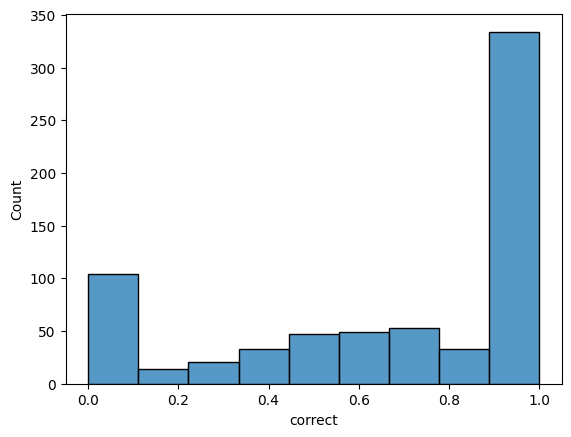

In [12]:
corec = truth.groupby('pid').correct.mean()
sns.histplot(corec, bins=corec.nunique())

In [13]:
model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [14]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [15]:
# load questions

file_path = "turl_test_2k_prompts_50.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [16]:
%%time

# tokenize inputs

tokenized = []

for idx, p in enumerate(prompts):
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt")
    p['pid'] = idx
    p['prompt'] = prompt
    p['tokenized'] = inputs
    tokenized.append(p)

Token indices sequence length is longer than the specified maximum sequence length for this model (4857 > 4096). Running this sequence through the model will result in indexing errors


CPU times: user 12 s, sys: 132 ms, total: 12.1 s
Wall time: 12.1 s


In [17]:
%%time

prompt_lenghts = []

for p in tokenized:
    plen = p['tokenized']['input_ids'][0].shape[0]
    
    cand_len = len(p['question'].split('>,')) - 1
    cand_pos = [idx for idx, cand in enumerate(p['question'].split('>,')) if p['output'] in cand + '>']
    
    # extract candidates
    candidates = p['question'].split(',. What')[0].split('<')[1:]
    candidates = [c.replace('>,', '').replace('>', '') for c in candidates]
    
    candidates_clean = [c.replace('[DESCRIPTION] ', '').replace('[DESC] ', '').replace('[TYPE] ', '').lower() for c in candidates]
    candidates_clean = [c for c in candidates_clean if c]
    
    candidates_clean_seq = [tokenizer(c, return_tensors="pt")['input_ids'].tolist()[0] for c in candidates_clean]
    
    prompt_lenghts.append((p['pid'], len(p['prompt']), plen, cand_len, cand_pos, candidates, candidates_clean, candidates_clean_seq))

pl = pd.DataFrame(prompt_lenghts, columns=['pid', 'char_len', 'tok_len', 'cand_len', 'cand_pos', 'cand', 'cand_clean', 'cand_clean_seq'])
pl['cand_pos_first'] = pl.cand_pos.str[0]

CPU times: user 6.76 s, sys: 99.3 ms, total: 6.86 s
Wall time: 6.85 s


In [18]:
pl.cand_len

0       49
1       50
2       49
3       49
4       49
        ..
1796    50
1797    52
1798    50
1799    49
1800    49
Name: cand_len, Length: 1801, dtype: int64

In [19]:
truth

,run,pid,correct,hallucinated
0,0,9,False,False
1,1,9,False,False
2,2,9,True,False
3,0,10,False,False
4,1,10,False,False
...,...,...,...,...
3435,7,1788,True,False
3436,7,1789,True,False
3437,7,1790,False,False
3438,7,1794,True,False


In [20]:
a = answers.merge(pl, on='pid', how='left')
a['reconstructed'] = a.apply(lambda row: row['cand'][row['cand_pos_first']], axis=1)
a['correct'] = (a.answer.str.lower() == a.reconstructed.str.lower())

In [21]:
a.shape

(5504, 15)

In [22]:
deb = a.merge(truth, on=['run', 'pid'])
deb['cand_present'] = deb.apply(lambda row: any([el.lower() == row['answer'].lower() for el in row['cand_clean']]), axis=1)

In [23]:
# TODO debug di questi casi residuali in cui la ricostruzione del candidato non coincide con 'truth' importato
# (validato in tablellama-plot)
deb[(deb.correct_x != deb.correct_y)]

,run,pid,answer,answer_seq,right_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first,reconstructed,correct_x,correct_y,hallucinated,cand_present
33,0,38,Karan Ashley [DESC] American actress [TYPE] Television actor,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<karan ashley [desc] american actress [type] television actor>,16227,5596,50,[8],"[B 12 , C 12 , and the Red Giants [DESC] scientific article [TYPE] scholarly article, Ancient Roman Statutes...","[b 12 , c 12 , and the red giants scientific article scholarly article, ancient roman statutes: a translatio...","[[1, 289, 1678, 29896, 29906, 268, 1919, 268, 274, 1678, 29896, 29906, 268, 1919, 322, 278, 2654, 4005, 1934, 16021, 4274, 2...",8,"lk refid=""m4.10"" [DESC] article [TYPE] scholarly article",False,True,False,False
34,1,38,Karan Ashley [DESC] American actress [TYPE] Television actor,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<karan ashley [desc] american actress [type] television actor>,16227,5596,50,[8],"[B 12 , C 12 , and the Red Giants [DESC] scientific article [TYPE] scholarly article, Ancient Roman Statutes...","[b 12 , c 12 , and the red giants scientific article scholarly article, ancient roman statutes: a translatio...","[[1, 289, 1678, 29896, 29906, 268, 1919, 268, 274, 1678, 29896, 29906, 268, 1919, 322, 278, 2654, 4005, 1934, 16021, 4274, 2...",8,"lk refid=""m4.10"" [DESC] article [TYPE] scholarly article",False,True,False,False
35,2,38,Karan Ashley [DESC] American actress [TYPE] Television actor,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<karan ashley [desc] american actress [type] television actor>,16227,5596,50,[8],"[B 12 , C 12 , and the Red Giants [DESC] scientific article [TYPE] scholarly article, Ancient Roman Statutes...","[b 12 , c 12 , and the red giants scientific article scholarly article, ancient roman statutes: a translatio...","[[1, 289, 1678, 29896, 29906, 268, 1919, 268, 274, 1678, 29896, 29906, 268, 1919, 322, 278, 2654, 4005, 1934, 16021, 4274, 2...",8,"lk refid=""m4.10"" [DESC] article [TYPE] scholarly article",False,True,False,False
234,0,217,Patrick Eaves [DESC] Canadian born-American ice hockey player [TYPE] ice hockey player,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<patrick eaves [desc] canadian born-american ice hockey player [type] ice hockey player>,7007,1939,49,[33],"[Thackit Eaves [DESC] architectural structure in Northill, Central Bedfordshire, Bedfordshire, UK [TYPE] thatched cottage, T...","[thackit eaves architectural structure in northill, central bedfordshire, bedfordshire, uk thatched cottage, the eaves archi...","[[1, 266, 547, 277, 321, 5989, 6956, 3631, 3829, 297, 6641, 453, 29892, 6555, 6592, 4006, 11750, 29892, 6592, 4006, 11750, 2...",33,"Boston Baptist College [DESC] Baptist bible college in Milton, Massachusetts [TYPE] private not-for-profit educational insti...",False,True,False,False
235,1,217,Patrick Eaves [DESC] Canadian born-American ice hockey player [TYPE] ice hockey player,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<patrick eaves [desc] canadian born-american ice hockey player [type] ice hockey player>,7007,1939,49,[33],"[Thackit Eaves [DESC] architectural structure in Northill, Central Bedfordshire, Bedfordshire, UK [TYPE] thatched cottage, T...","[thackit eaves architectural structure in northill, central bedfordshire, bedfordshire, uk thatched cottage, the eaves archi...","[[1, 266, 547, 277, 321, 5989, 6956, 3631, 3829, 297, 6641, 453, 29892, 6555, 6592, 4006, 11750, 29892, 6592, 4006, 11750, 2...",33,"Boston Baptist College [DESC] Baptist b

In [24]:
# allucinazioni
deb[(~deb.cand_present) & (deb.hallucinated)]

,run,pid,answer,answer_seq,right_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first,reconstructed,correct_x,correct_y,hallucinated,cand_present
98,2,89,2010 Garmin-Transitions [DESCRIPTION] None [TYPE] cycling team season,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<ef education-easypost [desc] american professional men's cycling team [type] uci continental team>,13310,6844,2,[0],"[EF Education-EasyPost [DESC] American professional men's cycling team [TYPE] UCI Continental Team, 2010 Garmin-Transitions ...","[ef education-easypost american professional men's cycling team uci continental team, 2010 garmin-transitions none cycling t...","[[1, 321, 29888, 9793, 29899, 29872, 294, 1478, 520, 7902, 2185, 10257, 1757, 29915, 29879, 5094, 19914, 3815, 318, 455, 214...",0,EF Education-EasyPost [DESC] American professional men's cycling team [TYPE] UCI Continental Team,False,False,True,False
124,1,112,Chile [DESCRIPTION] country in South America [TYPE] OECD country,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<chile [desc] country in south america [type] oecd country>,6904,2594,50,[11],"[Meling ( rosnes ) [DESC] rock art in Stavanger, Rogaland, Norway [TYPE] rock art, Yanggum ( 양금 ) [DESC] yanggum at the Metr...","[meling ( rosnes ) rock art in stavanger, rogaland, norway rock art, yanggum ( 양금 ) yanggum at the metropolitan museum of ar...","[[1, 9232, 292, 313, 14652, 4515, 1723, 7679, 1616, 297, 380, 485, 4600, 29892, 696, 29887, 11627, 29892, 3643, 1582, 7679, ...",11,Chile [DESC] country in South America [TYPE] OECD country,False,False,True,False
195,0,187,"Chinatown [DESCRIPTION] neighborhood in Philadelphia, Pennsylvania, United States [TYPE] neighborhood","[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...","<chinatown [desc] neighborhood in philadelphia, pennsylvania, united states [type] neighborhood>",22532,7351,50,[27],[The ablest professor in the cabinet of the tact by which power is kept: it is his mission to counteract the talk by which i...,[the ablest professor in the cabinet of the tact by which power is kept: it is his mission to counteract the talk by which i...,"[[1, 278, 633, 29880, 342, 12251, 297, 278, 28966, 310, 278, 28476, 491, 607, 3081, 338, 8126, 29901, 372, 338, 670, 10655, ...",27,"Chinatown [DESC] neighborhood in Philadelphia, Pennsylvania, United States [TYPE] neighborhood",False,False,True,False
196,1,187,"Chinatown [DESCRIPTION] neighborhood in Philadelphia, Pennsylvania, United States [TYPE] neighborhood","[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...","<chinatown [desc] neighborhood in philadelphia, pennsylvania, united states [type] neighborhood>",22532,7351,50,[27],[The ablest professor in the cabinet of the tact by which power is kept: it is his mission to counteract the talk by which i...,[the ablest professor in the cabinet of the tact by which power is kept: it is his mission to counteract the talk by which i...,"[[1, 278, 633, 29880, 342, 12251, 297, 278, 28966, 310, 278, 28476, 491, 607, 3081, 338, 8126, 29901, 372, 338, 670, 10655, ...",27,"Chinatown [DESC] neighborhood in Philadelphia, Pennsylvania, United States [TYPE] neighborhood",False,False,True,False
197,2,187,"Chinatown [DESCRIPTION] neighborhood in Philadelphia, Pennsylvania, United States [TYPE] neighborhood","[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...","<chinatown [desc] neighborhood in philadelphia, pennsylvania, united states [type] neighborhood>",22532,7351,50,[27],[The ablest professor in the cabinet of the tact by which power is kept: it is his mission to counteract the talk by whi

In [25]:
def cleanup_before_she_comes(mystr):
    mystr = mystr.replace('[DESC] ', '').replace('[DESCRIPTION] ', '').replace('[TYPE] ', '')
    # if ']' in mystr or '[' in mystr: print(mystr)
    return mystr

a['answer_clean'] = a.answer.apply(lambda x: cleanup_before_she_comes(x)).str.lower()
a['right_answer_clean'] = a['right_answer'].str.replace('[description] ', '').str.replace('[desc] ', '').str.replace('[type] ', '').str.replace('<', '').str.replace('>', '')


### distance among correct candidate and all candidates

In [26]:
from sentence_transformers import SentenceTransformer

device = torch.device("mps")
model = SentenceTransformer("all-mpnet-base-v2").to(device)


In [20]:
%%time

# do not compute the same embeddings many times
mycache = {}
myanscache = {}

if False:
    cc_ = []
    allc_ = []
    ans_ = []

    for row in a.itertuples():
        print(row.run, row.pid, end='\r')
        cc = row.right_answer_clean
        allc = row.cand_clean

        allc_tuple = tuple(allc)
        if (cc, allc_tuple) in mycache:
            (cc_embeddings, allc_embeddings) = mycache[(cc, allc_tuple)]
        else:
            cc_embeddings = model.encode([cc])
            allc_embeddings = model.encode(allc)
            mycache[(cc, allc_tuple)] = (cc_embeddings, allc_embeddings)    
        cc_.append(cc_embeddings)
        allc_.append(allc_embeddings)
            
        ans = row.answer_clean    
        if ans in myanscache:
            ans_embeddings = myanscache[ans]
        else:
            ans_embeddings = model.encode([ans])
            myanscache[ans] = ans_embeddings 
        ans_.append(ans_embeddings)
        

    a['right_answer_clean_embedding'] = cc_
    a['cand_clean_embedding'] = allc_
    a['answer_clean_embedding'] = ans_
    
    import pickle
    with open('cohesion.pickle', 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 2min 10s, sys: 25.5 s, total: 2min 36s
Wall time: 1min 46s


In [27]:
with open('cohesion.pickle', 'rb') as handle:
        a = pickle.load(handle)

In [28]:
a.shape, a[a.cand_len>=10].shape

((5504, 20), (5336, 20))

In [29]:
# at least 10 candidates
a = a[a.cand_len>=10]

In [30]:
%%time

# extract cosine similarities among right candidate and all candidates (cold measure)
from sentence_transformers.util import cos_sim
a['cos_sim_right_cand'] = a.apply(lambda x: cos_sim(x['right_answer_clean_embedding'], x['cand_clean_embedding']), axis=1)

CPU times: user 2.24 s, sys: 227 ms, total: 2.46 s
Wall time: 312 ms


In [31]:
# tensor to list
a['cos_sim_right_cand'] = a.apply(lambda x: x['cos_sim_right_cand'].tolist()[0], axis=1)

In [32]:
# check max sim is always self
a['cos_sim_right_cand'].apply(lambda x: max(x))

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
5499    1.0
5500    1.0
5501    1.0
5502    1.0
5503    1.0
Name: cos_sim_right_cand, Length: 5336, dtype: float64

In [33]:
# min candidates
a.apply(lambda x: len(x.cos_sim_right_cand), axis=1).min()

10

In [34]:
a.loc[0]['cand_clean_embedding'].shape

(49, 768)

In [35]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

def cosine_distance_stats(embeddings):
    D = pairwise_distances(embeddings, metric="cosine")
    triu_indices = np.triu_indices_from(D, k=1)  # upper triangular indices without diagonal
    distances = D[triu_indices]
    return (np.mean(distances), np.min(distances), np.max(distances), np.var(distances))

# gini ~ 0 -> uniform distances -> high cohesion
# gini ~ 1 -> variable distances -> low cohesion
def gini_coefficient(embeddings):
    D = pairwise_distances(embeddings, metric="cosine")
    triu_indices = np.triu_indices_from(D, k=1)  # upper triangular indices without diagonal
    distances = np.sort(D[triu_indices])  # sort
    n = len(distances)
    if n == 0:
        return 0
    index = np.arange(1, n + 1)  # index array
    return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index

import scipy.spatial
import scipy.linalg

def spectral_gap(embeddings):   
    try:
        # spectral gap (λ2) of the graph Laplacian from a distance matrix
        D = pairwise_distances(embeddings, metric="cosine")

        # distances to similarities
        sigma = np.median(D)  # scale
        W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix

        # Laplacian
        D_matrix = np.diag(W.sum(axis=1))
        L = D_matrix - W  # graph laplacian

        # eigenvalues
        eigenvalues = np.linalg.eigvalsh(L)
        return np.sort(eigenvalues)[1]  # second smallest eigenvalue is the spectral gap
    except Exception as e:
        return None

In [36]:
import numpy as np
import itertools

def jaccard_similarity(list1, list2):
    intersection = len(set(list1) & set(list2))
    union = len(set(list1)) + len(set(list2)) - intersection
    return float(intersection) / union if union != 0 else 0.0

def jaccard_upper_triangle(lists):
    n = len(lists)
    distances = []
    
    for i, j in itertools.combinations(range(n), 2):
        similarity = jaccard_similarity(lists[i], lists[j])
        distances.append(1 - similarity)

    return distances

def jaccard_distance_stats(mylist):
    if type(mylist[0]) == str: mylist = [l.split(' ') for l in mylist] # convert to list if string
    distances = jaccard_upper_triangle(mylist)
    return (np.mean(distances), np.min(distances), np.max(distances), np.var(distances))


In [37]:
%%time

# measures of consistency among candidates (also considering the right one)
# these measures are constant across runs (and can be used as input features)

# VRO w.r.t. correct answer 
a['right_cand_avg_dist'] = a.swifter.apply(lambda x: 1. - (sum(x.cos_sim_right_cand) - 1.) / (len(x.cos_sim_right_cand) - 1), axis=1)

# distance from the nearest
a['right_cand_mindist'] = a.swifter.apply(lambda x: 1. - x.cos_sim_right_cand[np.argpartition(x.cos_sim_right_cand, -2)[-2]], axis=1) # second largest distance

# distance matrix stats
a[['cand_average_dist','cand_min_dist','cand_max_dist','cand_variance_of_dist']] = a.swifter.apply(lambda x: cosine_distance_stats(x.cand_clean_embedding), axis=1, result_type='expand') 

# jaccard on words and tokens
a[['cand_average_jaccard_dist','cand_min_jaccard_dist','cand_max_jaccard_dist','cand_variance_of_jaccard_dist']] = a.swifter.apply(lambda x: jaccard_distance_stats(x.cand_clean), axis=1, result_type='expand') 
a[['cand_average_jaccard_tok_dist','cand_min_jaccard_tok_dist','cand_max_jaccard_tok_dist','cand_variance_of_jaccard_tok_dist']] = a.swifter.apply(lambda x: jaccard_distance_stats(x.cand_clean_seq), axis=1, result_type='expand') 

# gini coefficient
a['cand_gini_coef'] = a.swifter.apply(lambda x: gini_coefficient(x.cand_clean_embedding), axis=1) # gini coefficient

# spectral gap
a['cand_spectral_gap'] = a.swifter.apply(lambda x: spectral_gap(x.cand_clean_embedding), axis=1) # spectral gap


Pandas Apply:   0%|          | 0/5336 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5336 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5336 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5336 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5336 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5336 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5336 [00:00<?, ?it/s]

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n

CPU times: user 39.8 s, sys: 45 s, total: 1min 24s
Wall time: 32.1 s


/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix


In [38]:
# TODO debug these mofos (most probably broken candidates lists)
a[a['cand_spectral_gap'].isna()]

,run,pid,answer,answer_seq,right_answer,char_len,tok_len,cand_len,cand_pos,cand,...,cand_average_jaccard_dist,cand_min_jaccard_dist,cand_max_jaccard_dist,cand_variance_of_jaccard_dist,cand_average_jaccard_tok_dist,cand_min_jaccard_tok_dist,cand_max_jaccard_tok_dist,cand_variance_of_jaccard_tok_dist,cand_gini_coef,cand_spectral_gap
1509,0,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<2002 asian games [desc] 14th edition of the asian games [type] multi-sport event>,3277,1280,50,[14],"[XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DE...",...,0.04,0.0,1.0,0.0384,0.038095,0.0,0.952381,0.03483,0.96,NaN
1510,1,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<2002 asian games [desc] 14th edition of the asian games [type] multi-sport event>,3277,1280,50,[14],"[XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DE...",...,0.04,0.0,1.0,0.0384,0.038095,0.0,0.952381,0.03483,0.96,NaN
1511,2,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<2002 asian games [desc] 14th edition of the asian games [type] multi-sport event>,3277,1280,50,[14],"[XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DE...",...,0.04,0.0,1.0,0.0384,0.038095,0.0,0.952381,0.03483,0.96,NaN
2567,3,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,NaN,<2002 asian games [desc] 14th edition of the asian games [type] multi-sport event>,3277,1280,50,[14],"[XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DE...",...,0.04,0.0,1.0,0.0384,0.038095,0.0,0.952381,0.03483,0.96,NaN
3255,4,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,NaN,<2002 asian games [desc] 14th edition of the asian games [type] multi-sport event>,3277,1280,50,[14],"[XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DE...",...,0.04,0.0,1.0,0.0384,0.038095,0.0,0.952381,0.03483,0.96,NaN
3943,5,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,NaN,<2002 asian games [desc] 14th edition of the asian games [type] multi-sport event>,3277,1280,50,[14],"[XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DE...",...,0.04,0.0,1.0,0.0384,0.038095,0.0,0.952381,0.03483,0.96,NaN
4631,6,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,NaN,<2002 asian games [desc] 14th edition of the asian games [type] multi-sport event>,3277,1280,50,[14],"[XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DE...",...,0.04,0.0,1.0,0.0384,0.038095,0.0,0.952381,0.03483,0.96,NaN
5319,7,1337,2002 Asian Games [DESC] 14th edition of the Asian Games [TYPE] multi-sport event,NaN,<2002 asian games [desc] 14th edition of the asian games [type] multi-sport event>,3277,1280,50,[14],"[XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DESC] None [TYPE] None, XIV [DE...",...,0.04,0.0,1.0,0.0384,0.038095,0.0,0.952381,0.03483,0.96,NaN


In [39]:
a = a[~a['cand_spectral_gap'].isna()]

### candidate cohesion VS avg accuracy

In [41]:
# there is no variance here! drop_duplicates and keep='first' should give the very same result

aggro = a.groupby('pid').agg({'correct': 'mean', 
                              'right_cand_avg_dist': ['mean', 'std'], 
                              'right_cand_mindist': ['mean', 'std'],
                              'cand_variance_of_dist': ['mean', 'std'],
                              'cand_gini_coef': ['mean', 'std'],
                              'cand_spectral_gap': ['mean', 'std'],
                              'cand_average_dist': ['mean', 'std'],
                              'cand_min_dist': ['mean', 'std'],
                              'cand_max_dist': ['mean', 'std'],
                              'cand_variance_of_dist': ['mean', 'std'],
                              'cand_average_jaccard_dist': ['mean', 'std'],
                              'cand_min_jaccard_dist': ['mean', 'std'],
                              'cand_max_jaccard_dist': ['mean', 'std'],
                              'cand_variance_of_jaccard_dist': ['mean', 'std'],
                              'cand_average_jaccard_tok_dist': ['mean', 'std'],
                              'cand_min_jaccard_tok_dist': ['mean', 'std'],
                              'cand_max_jaccard_tok_dist': ['mean', 'std'],
                              'cand_variance_of_jaccard_tok_dist': ['mean', 'std']
                             })


In [42]:
aggro.columns = ['_'.join([str(c) for c in col]).strip() for col in aggro.columns.values]

In [43]:
# must be true (no variance on measures not supposed to vary)
aggro[[c for c in aggro.columns if c.endswith('_std')]].sum().sum() == 0.

True

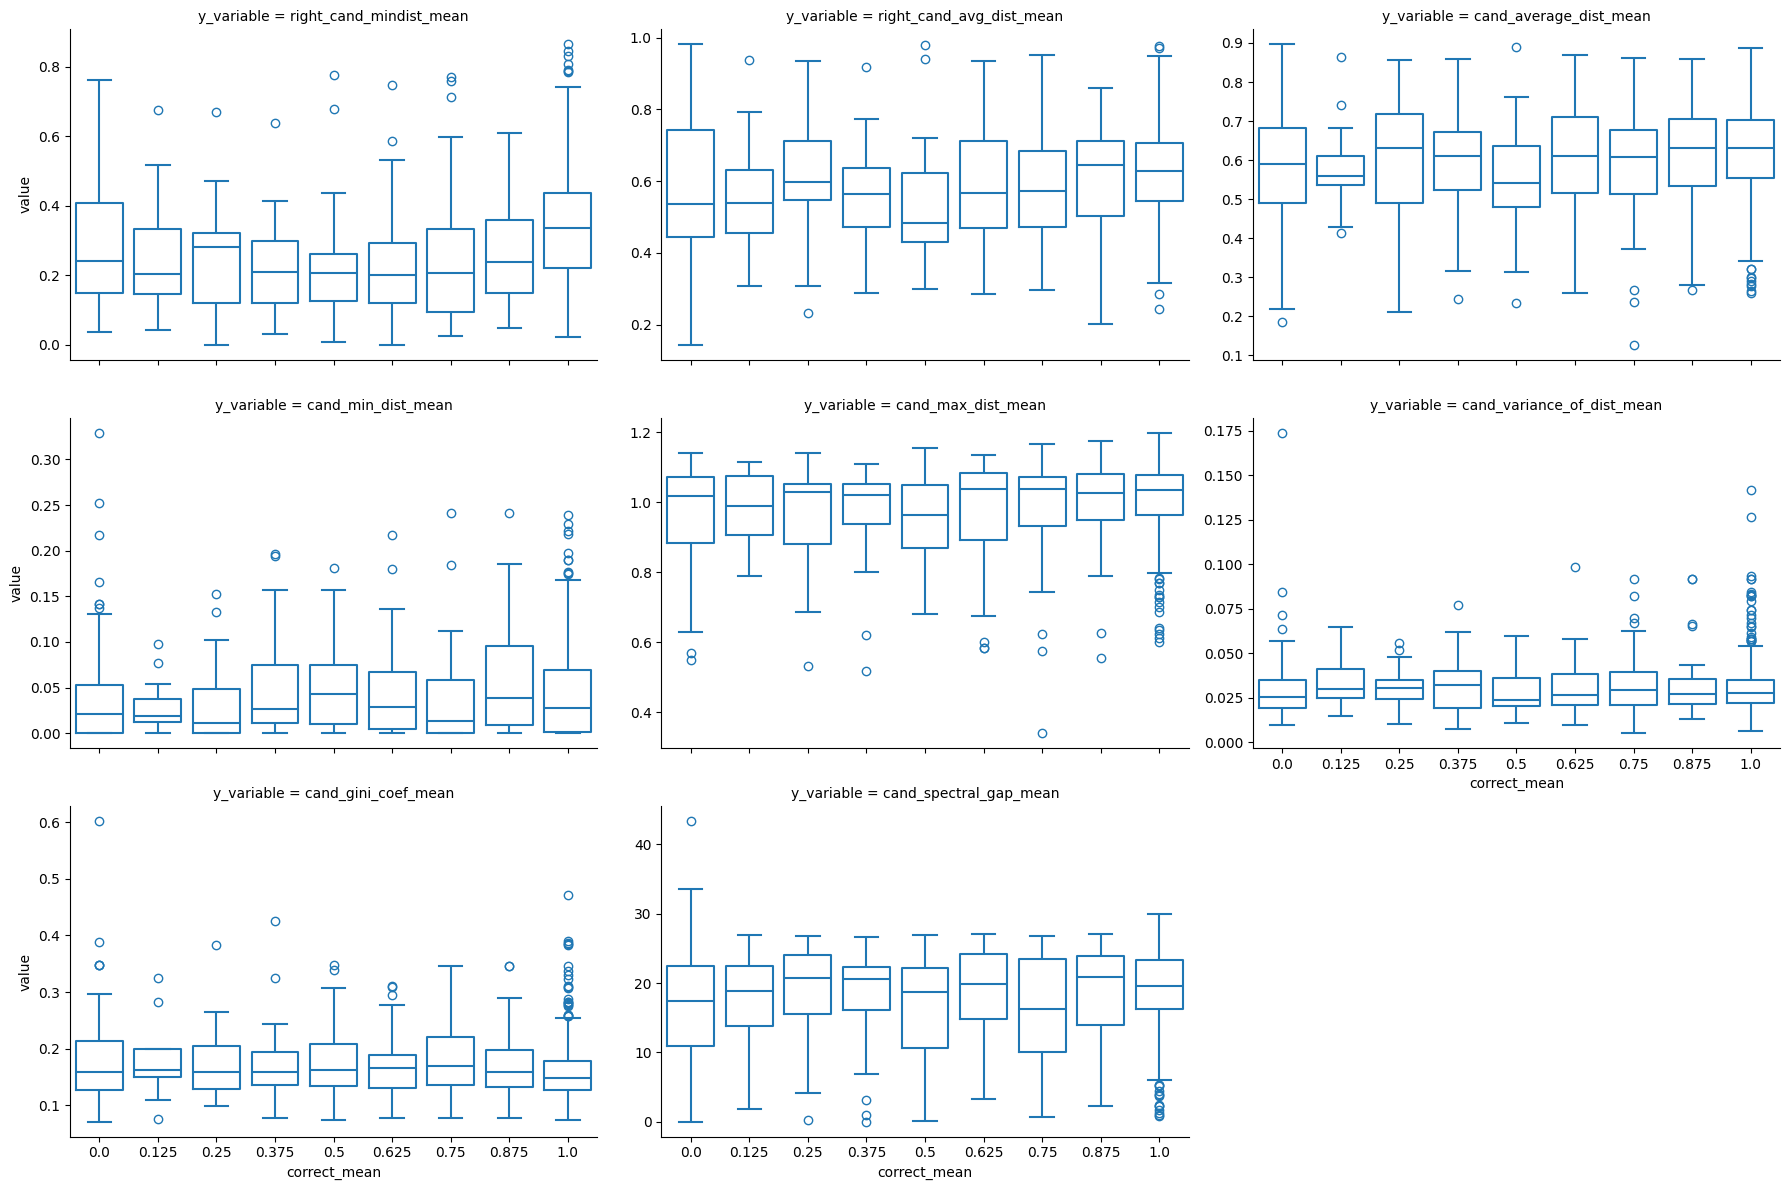

In [44]:

y_vars = ['right_cand_mindist_mean', 
          'right_cand_avg_dist_mean', 
          'cand_average_dist_mean',
          'cand_min_dist_mean',
          'cand_max_dist_mean',
          'cand_variance_of_dist_mean',
          'cand_gini_coef_mean',
          'cand_spectral_gap_mean']


# Reshape DataFrame to long format using `melt`
aggro_melted = aggro.melt(id_vars=["correct_mean"], value_vars=y_vars, 
                          var_name="y_variable", value_name="value")


# Create FacetGrid for multiple y-variables
g = sns.FacetGrid(aggro_melted, col="y_variable", height=4, aspect=1.5, 
                  sharex=True, sharey=False, col_wrap=3)

# Map plot to each facet
# g.map_dataframe(sns.violinplot, x="correct_mean", y="value", split=True, fill=False, inner="quart")
g.map_dataframe(sns.boxplot, x="correct_mean", y="value", fill=False)

<Axes: >

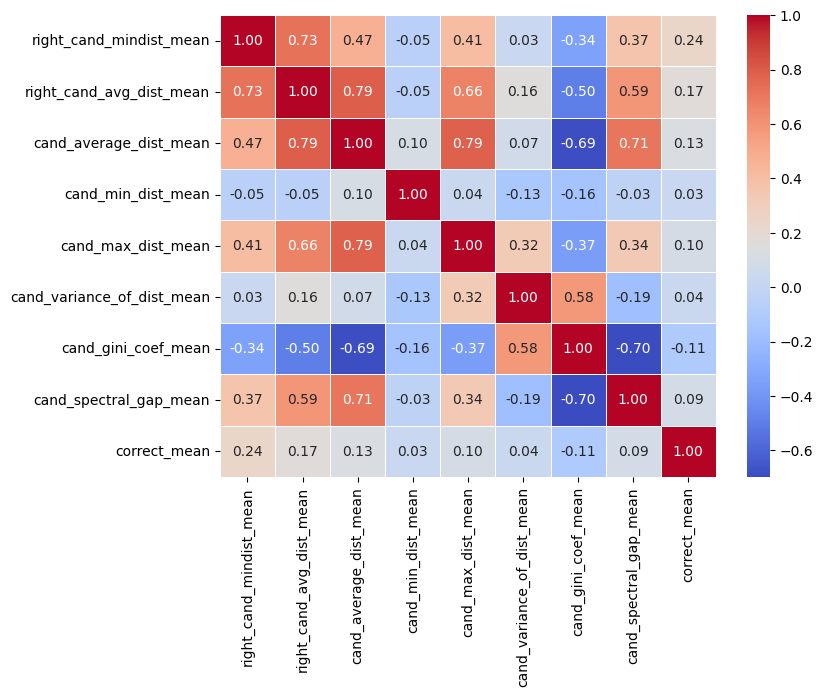

In [45]:
corr_matrix = aggro[['right_cand_mindist_mean', 
                     'right_cand_avg_dist_mean', 
                     'cand_average_dist_mean',
                     'cand_min_dist_mean',
                     'cand_max_dist_mean',
                     'cand_variance_of_dist_mean',
                     'cand_gini_coef_mean',
                     'cand_spectral_gap_mean',
                     'correct_mean']].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

<Axes: >

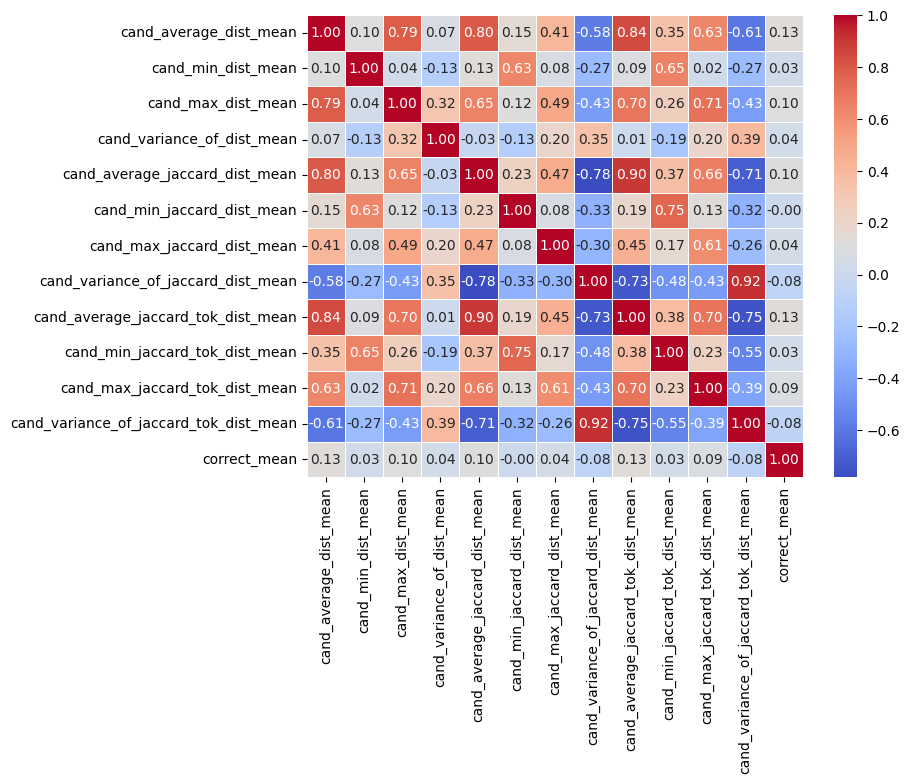

In [46]:
# distanze tra input

corr_matrix = aggro[['cand_average_dist_mean',
                     'cand_min_dist_mean',
                     'cand_max_dist_mean',
                     'cand_variance_of_dist_mean',
                     'cand_average_jaccard_dist_mean',
                     'cand_min_jaccard_dist_mean',
                     'cand_max_jaccard_dist_mean',
                     'cand_variance_of_jaccard_dist_mean',
                     'cand_average_jaccard_tok_dist_mean',
                     'cand_min_jaccard_tok_dist_mean',
                     'cand_max_jaccard_tok_dist_mean',
                     'cand_variance_of_jaccard_tok_dist_mean',
                     'correct_mean'
]].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

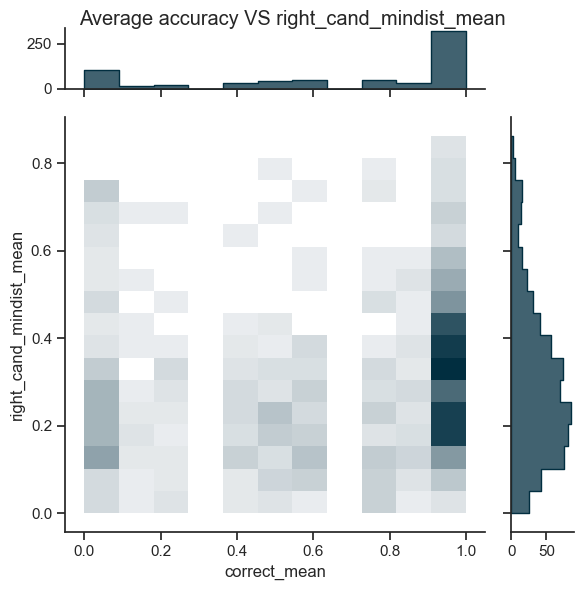

In [47]:
import seaborn as sns
sns.set_theme(style="ticks")

# most correlated
g = sns.JointGrid(data=aggro, x='correct_mean', y='right_cand_mindist_mean', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#012E40")

g.fig.suptitle("Average accuracy VS right_cand_mindist_mean")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

In [48]:
# collect answer text and embeddings per each prompt

ac = a.groupby('pid')['answer_clean'].apply(list).reset_index()
ace = a.groupby('pid')['answer_clean_embedding'].apply(list).apply(lambda x: np.vstack(x)).reset_index()

In [49]:
a.loc[0].cand_clean_embedding.shape, ace.loc[0].answer_clean_embedding.shape

((49, 768), (8, 768))

In [51]:
ac = ac.merge(ace, on='pid').merge(a[['pid', 'right_answer_clean_embedding']], on='pid', how='left')

In [52]:
%%time

# these depend on knowing the right answer

# extract cosine similarities among right candidate and all outputted  answers
from sentence_transformers.util import cos_sim
ac['cos_sim_right_and_answers'] = ac.apply(lambda x: cos_sim(x['right_answer_clean_embedding'], x['answer_clean_embedding']), axis=1)
ac['cos_sim_right_and_answers'] = ac.apply(lambda x: x['cos_sim_right_and_answers'].tolist()[0], axis=1)

# measures of consistency among output values
ac['right_and_answers_avg_dist'] = ac.apply(lambda x: 1. - (sum(x.cos_sim_right_and_answers) - 1.) / (len(x.cos_sim_right_and_answers) - 1), axis=1)
# distance from the nearest
ac['right_and_answers_mindist'] = ac.apply(lambda x: 1. - x.cos_sim_right_and_answers[np.argpartition(x.cos_sim_right_and_answers, -2)[-2]], axis=1) # second largest distance

CPU times: user 275 ms, sys: 3.18 ms, total: 278 ms
Wall time: 279 ms


In [53]:
%%time

# distance matrix stats
ac[['answers_average_dist','answers_min_dist','answers_max_dist','answers_variance_of_dist']] = ac.apply(lambda x: cosine_distance_stats(x.answer_clean_embedding), axis=1, result_type='expand') 

# gini coefficient
ac['answers_gini_coef'] = ac.apply(lambda x: gini_coefficient(x.answer_clean_embedding), axis=1) # gini coefficient

ac['answers_spectral_gap'] = ac.apply(lambda x: spectral_gap(x.answer_clean_embedding), axis=1) # spectral gap

# number of answers (set measure)
ac['num_answers'] = ac.apply(lambda x: len(set(x.answer_clean)), axis=1)

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2kr

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2kr

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2

CPU times: user 3.72 s, sys: 34.7 ms, total: 3.75 s
Wall time: 2.76 s


In [54]:
ac[['answers_average_jaccard_dist','answers_min_jaccard_dist','answers_max_jaccard_dist','answers_variance_of_jaccard_dist']] = ac.swifter.apply(lambda x: jaccard_distance_stats(x.answer_clean), axis=1, result_type='expand') 

# seq not encoded in all experiments
# ac[['answers_average_jaccard_tok_dist','answers_min_jaccard_tok_dist','answers_max_jaccard_tok_dist','answers_variance_of_jaccard_tok_dist']] = ac.swifter.apply(lambda x: jaccard_distance_stats(x.answer_seq), axis=1, result_type='expand') 

Pandas Apply:   0%|          | 0/5328 [00:00<?, ?it/s]

In [57]:
# entropy of answers
from scipy.stats import entropy
from collections import Counter

ac['answers_freqs'] = ac.apply(lambda x: list(Counter(x.answer_clean).values()), axis = 1)
ac['answers_entropy'] = ac.apply(lambda x: entropy(x.answers_freqs), axis = 1)
ac['answers_entropy_norm'] = ac.apply(lambda x: x.answers_entropy /np.log2(len(x.answers_freqs)), axis = 1)

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_2226/1537127178.py:7: RuntimeWarning: invalid value encountered in scalar divide
  ac['answers_entropy_norm'] = ac.apply(lambda x: x.answers_entropy /np.log2(len(x.answers_freqs)), axis = 1)


In [58]:
(ac.answers_freqs.str.len() == ac.num_answers).sum() == ac.shape[0]

True

In [59]:
aggrodue = ac.merge(aggro.reset_index(), on='pid', how='inner')

<Axes: >

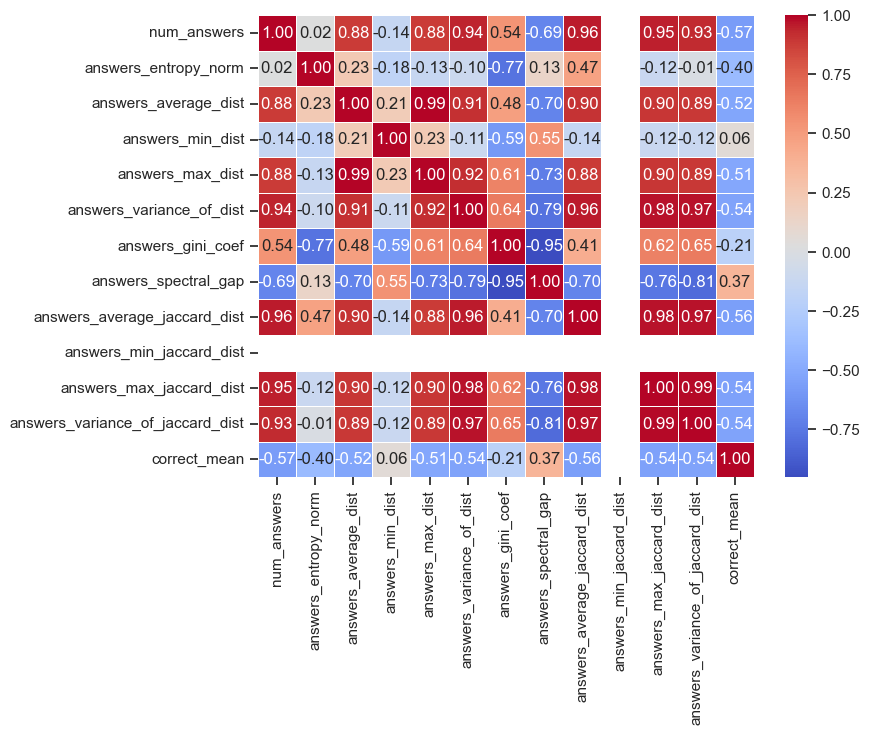

In [61]:
# correlazioni tra variabilità dell'output e accuracy

corr_matrix = aggrodue[['num_answers', 
                     'answers_entropy_norm', 
                     'answers_average_dist',
                     'answers_min_dist',
                     'answers_max_dist',
                     'answers_variance_of_dist',
                     'answers_gini_coef',
                     'answers_spectral_gap',
                     'answers_average_jaccard_dist',
                     'answers_min_jaccard_dist',
                     'answers_max_jaccard_dist',
                     'answers_variance_of_jaccard_dist',
                     'correct_mean']].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

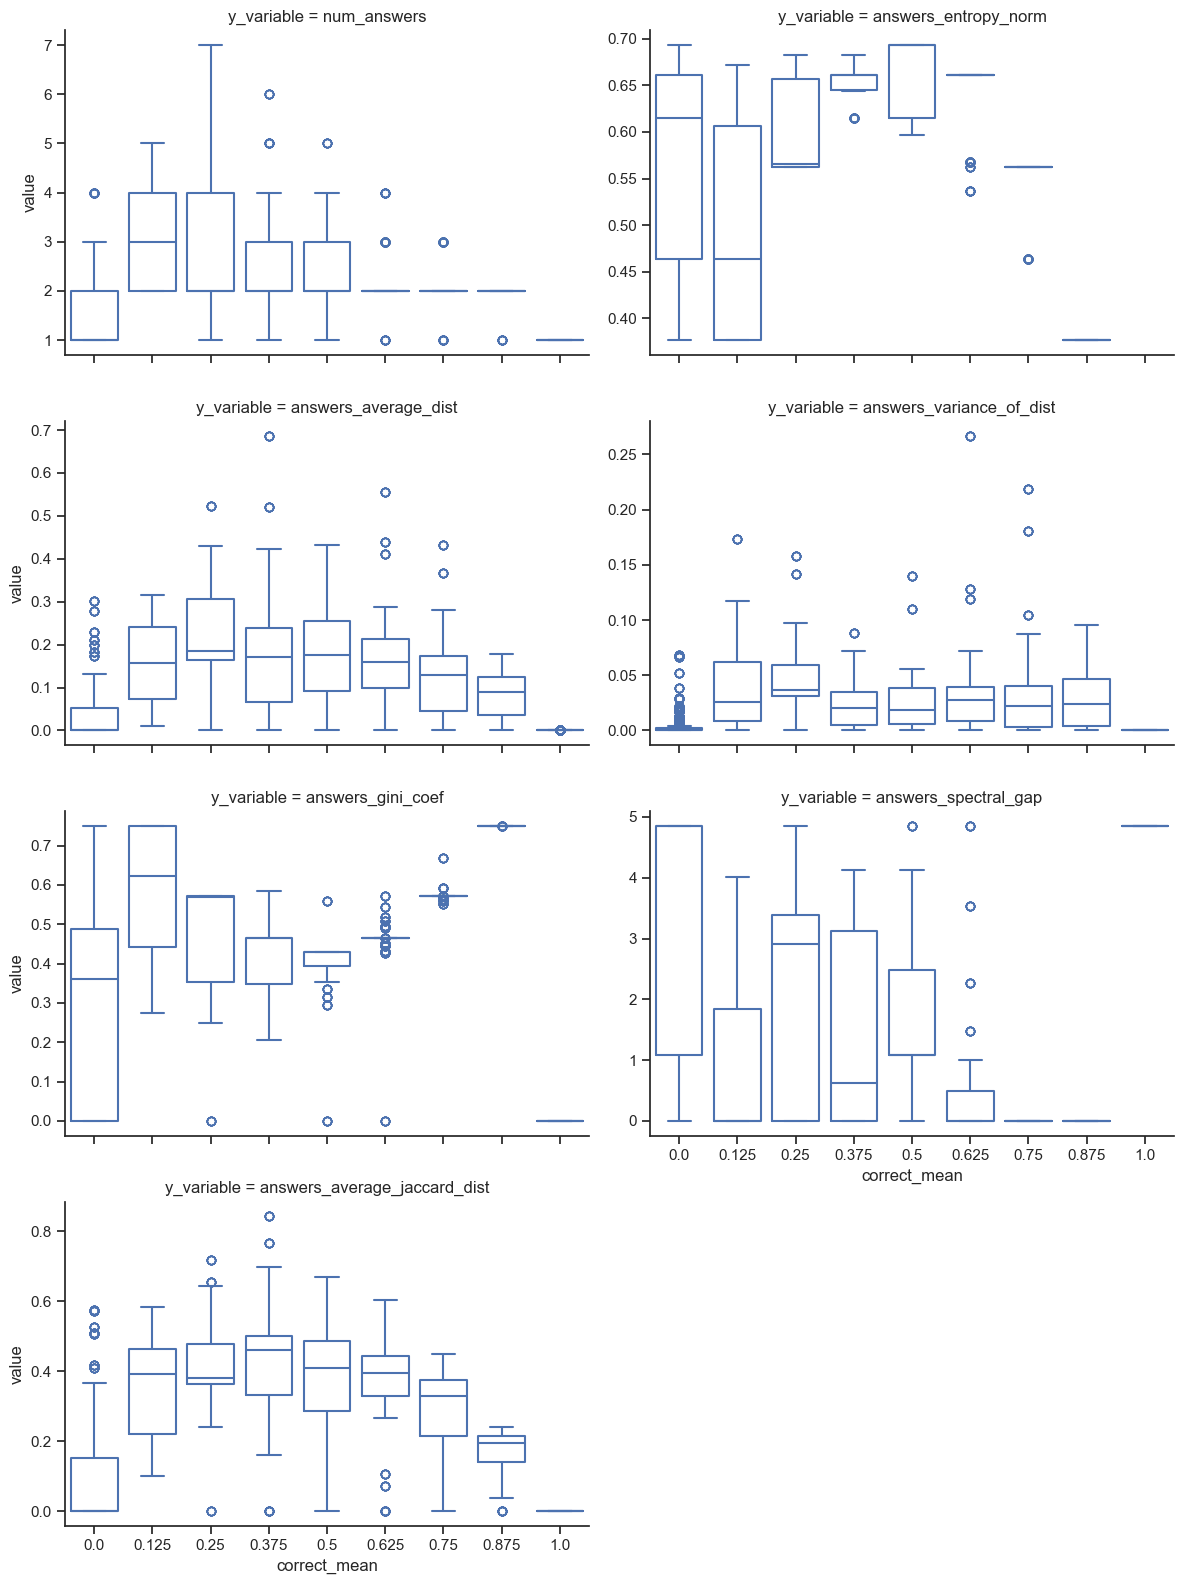

In [64]:

y_vars = ['num_answers', 
          'answers_entropy_norm', 
          'answers_average_dist', 
          'answers_variance_of_dist',
          'answers_gini_coef',
          'answers_spectral_gap',
          'answers_average_jaccard_dist']

# Reshape DataFrame to long format using `melt`
aggro_melted = aggrodue.melt(id_vars=["correct_mean"], value_vars=y_vars, 
                          var_name="y_variable", value_name="value")

# Create FacetGrid for multiple y-variables
g = sns.FacetGrid(aggro_melted, col="y_variable", height=4, aspect=1.5, sharex=True, sharey=False, col_wrap=2)

# Map violin plot to each facet
# g.map_dataframe(sns.violinplot, x="correct_mean", y="value", split=True, fill=False, inner="quart")
g.map_dataframe(sns.boxplot, x="correct_mean", y="value", fill=False)

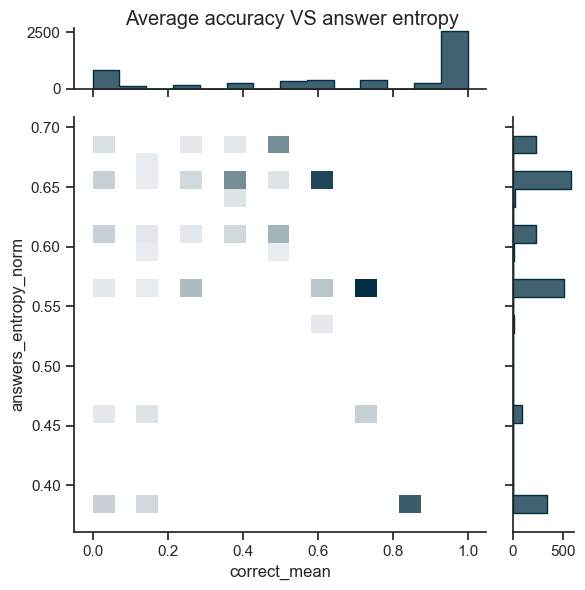

In [66]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='answers_entropy_norm', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#012E40")

g.fig.suptitle("Average accuracy VS answer entropy")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

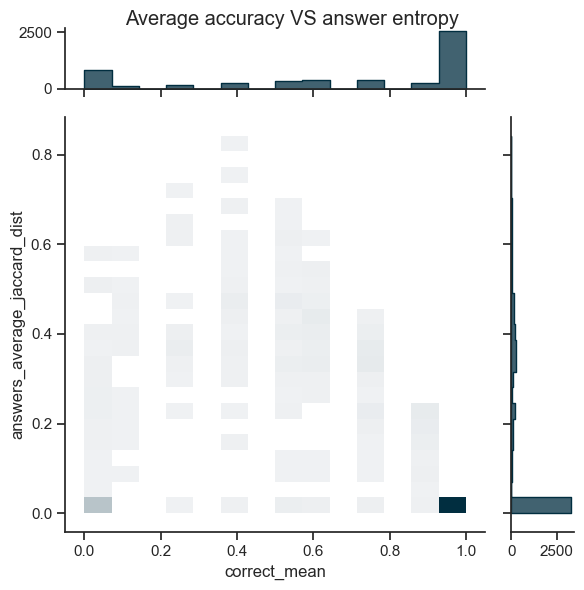

In [67]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='answers_average_jaccard_dist', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#012E40")

g.fig.suptitle("Average accuracy VS answer entropy")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

<Axes: xlabel='right_cand_mindist_mean', ylabel='cand_variance_of_distances'>

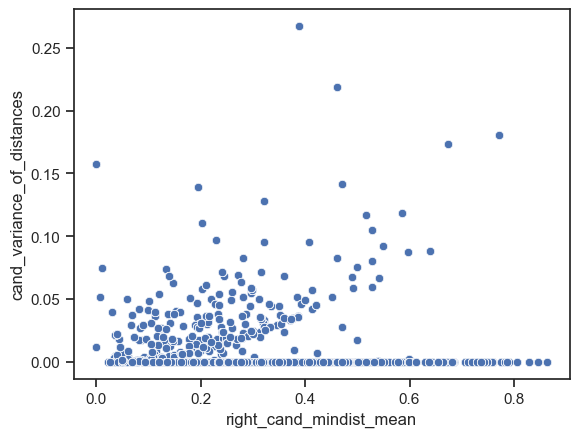

In [110]:
sns.scatterplot(aggrodue, x='right_cand_mindist_mean', y='cand_variance_of_distances')

In [ ]:
# TODO scatterplot cohesion (embeddings and/or implication) VS output variability

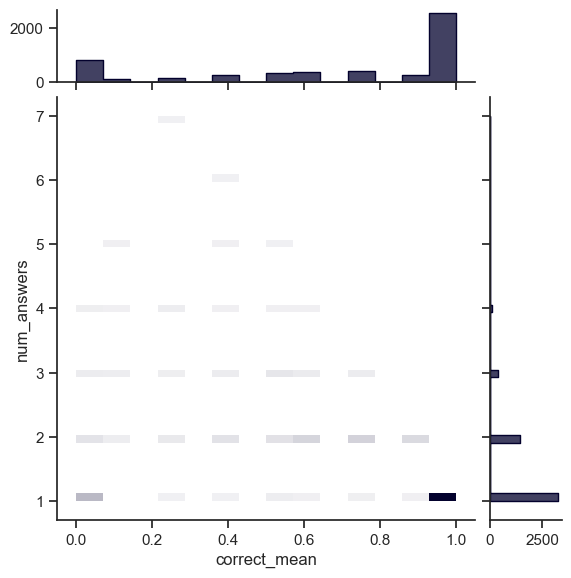

In [113]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='num_answers', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

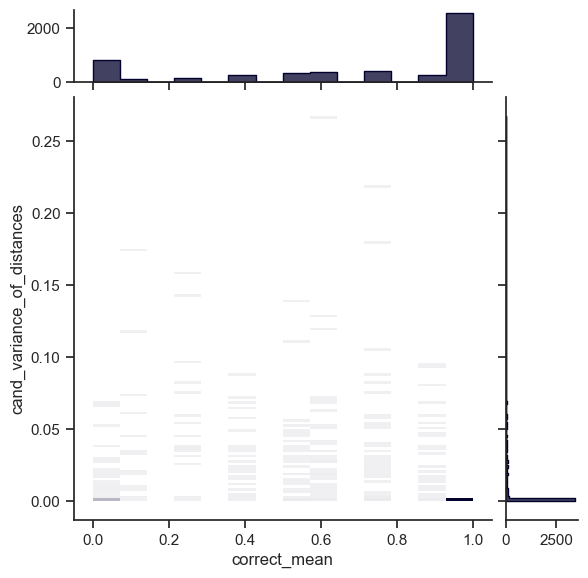

In [112]:

import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, y='cand_variance_of_distances', x='correct_mean', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

### entailment

In [2]:
DEVICE = "mps"

class BaseEntailment:
    def save_prediction_cache(self):
        pass


class EntailmentDeberta(BaseEntailment):
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xlarge-mnli")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            "microsoft/deberta-v2-xlarge-mnli").to(DEVICE)

    def check_implication(self, text1, text2, *args, **kwargs):
        inputs = self.tokenizer(text1, text2, return_tensors="pt").to(DEVICE)
        # The model checks if text1 -> text2, i.e. if text2 follows from text1.
        # check_implication('The weather is good', 'The weather is good and I like you') --> 1
        # check_implication('The weather is good and I like you', 'The weather is good') --> 2
        outputs = self.model(**inputs)
        logits = outputs.logits
        # Deberta-mnli returns `neutral` and `entailment` classes at indices 1 and 2.
        largest_index = torch.argmax(F.softmax(logits, dim=1))  # pylint: disable=no-member
        prediction = largest_index.cpu().item()

        # print('Deberta Input: %s -> %s', text1, text2)
        # print('Deberta Prediction: %s', prediction)

        return prediction


In [3]:
model = EntailmentDeberta()

tokenizer_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.77G [00:00<?, ?B/s]

In [5]:
s1 = "today is sunny and when it is sunny I am happy"
s2 = "today I am happy"
model.check_implication(s1, s2)

2

In [ ]:
candidates = p['question'].split(',. What')[0].split('<')[1:]
candidates = [c.replace('>,', '').replace('>', '') for c in candidates]